In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import gym_combrf

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import tqdm
import os

import torch
import torch.optim as optim
import torch.nn.functional as F




In [3]:
#initialize gym environment
env = gym.make('combrf-v0')

In [4]:
#hyper-parameters
UPDATE_EVERY = 50 #how often to update the network
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 0.9983
EPS_STEP_LIMIT = 50

TRAIN_EPISODES = 20
TEST_EPISODES = 1
seed = 0

#initialize GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Examine state and action spaces

In [5]:
#reset the environment
obs = env.reset()

#size of each action
action_size = env.action_space.shape
print("Size of each action: ", action_size)

#size of observation
print("Size of each observation: ", obs.shape)
print("Observation looks like:")
print(obs)

Size of each action:  (1,)
Size of each observation:  (130,)
Observation looks like:
[-9.85837812e-08 -1.97193427e-07 -1.60329127e-08  1.87874458e-07
  1.25233050e-07 -1.15084008e-07 -1.92124471e-07  3.41359421e-09
 -1.97193427e-07 -1.60329127e-08  1.87874458e-07  1.25233050e-07
 -1.15084008e-07 -1.92124471e-07  3.41359421e-09  1.94108588e-07
 -1.60329127e-08  1.87874458e-07  1.25233050e-07 -1.15084008e-07
 -1.92124471e-07  3.41359421e-09  1.94108588e-07  1.09410068e-07
  1.87874458e-07  1.25233050e-07 -1.15084008e-07 -1.92124471e-07
  3.41359421e-09  1.94108588e-07  1.09410068e-07 -1.30515087e-07
  1.25233050e-07 -1.15084008e-07 -1.92124471e-07  3.41359421e-09
  1.94108588e-07  1.09410068e-07 -1.30515087e-07 -1.85270649e-07
 -1.15084008e-07 -1.92124471e-07  3.41359421e-09  1.94108588e-07
  1.09410068e-07 -1.30515087e-07 -1.85270649e-07  2.28283883e-08
 -1.92124471e-07  3.41359421e-09  1.94108588e-07  1.09410068e-07
 -1.30515087e-07 -1.85270649e-07  2.28283883e-08  1.98539420e-07
  3.4

## Perform random actions in the environment

In [6]:
obs = env.reset()
count = 0
ep_rwd=0
while True:
    action = np.array([round(np.random.uniform(0,2*math.pi), 2)])
    obs, rwd, done, _ = env.step(action)
    ep_rwd += rwd
    count +=1
    if done:
        break
print("Random TX location: {0}".format(env.tx_loc))
print("Capacity: {0}".format(env.cap))
print("Episodic score: {0} with episode length: {1} ".format(ep_rwd, count))

Random TX location: [[   0 -400    0]]
Capacity: 4.5852698005869194e-08
Episodic score: 1.4681791524436894 with episode length: 8 


## Instantiate DDPG agent

In [19]:
#import custom classes
from Source.ddpg_rcv_agent import Agent
from Source.nn_model import Actor, Critic
from Source.ddpg_rcv_agent import Agent, ReplayBuffer, OUNoise
from collections import deque

#reset the environment
obs = env.reset()

state_size = obs.shape[0]
action_size = env.action_space.shape[0]

#instantiate the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

print(type(obs))
obs_tensor = torch.from_numpy(obs).float().to(device)
print(obs_tensor)

<class 'numpy.ndarray'>
tensor([ 5.2959e-08, -9.1027e-08,  1.2452e-07, -1.5175e-07,  1.7135e-07,
        -1.8234e-07,  1.8416e-07, -1.7672e-07, -9.1027e-08,  1.2452e-07,
        -1.5175e-07,  1.7135e-07, -1.8234e-07,  1.8416e-07, -1.7672e-07,
         1.6039e-07,  1.2452e-07, -1.5175e-07,  1.7135e-07, -1.8234e-07,
         1.8416e-07, -1.7672e-07,  1.6039e-07, -1.3600e-07, -1.5175e-07,
         1.7135e-07, -1.8234e-07,  1.8416e-07, -1.7672e-07,  1.6039e-07,
        -1.3600e-07,  1.0478e-07,  1.7135e-07, -1.8234e-07,  1.8416e-07,
        -1.7672e-07,  1.6039e-07, -1.3600e-07,  1.0478e-07, -6.8283e-08,
        -1.8234e-07,  1.8416e-07, -1.7672e-07,  1.6039e-07, -1.3600e-07,
         1.0478e-07, -6.8283e-08,  2.8356e-08,  1.8416e-07, -1.7672e-07,
         1.6039e-07, -1.3600e-07,  1.0478e-07, -6.8283e-08,  2.8356e-08,
         1.2996e-08, -1.7672e-07,  1.6039e-07, -1.3600e-07,  1.0478e-07,
        -6.8283e-08,  2.8356e-08,  1.2996e-08, -5.3695e-08,  1.7683e-07,
        -1.6058e-07,  1.362

## DDPG Training

Episode 1	Average Score: 6.80
Episode 2	Average Score: 6.74
Episode 3	Average Score: 6.67
Episode 4	Average Score: 6.70
Episode 5	Average Score: 6.82
Episode 6	Average Score: 6.66
Episode 7	Average Score: 6.62
Episode 8	Average Score: 6.55
Episode 9	Average Score: 6.39
Episode 10	Average Score: 6.46
Episode 11	Average Score: 6.42
Episode 12	Average Score: 6.46
Episode 13	Average Score: 6.45
Episode 14	Average Score: 6.10
Episode 15	Average Score: 6.10
Episode 16	Average Score: 6.16
Episode 17	Average Score: 6.17
Episode 18	Average Score: 6.23
Episode 19	Average Score: 6.19
Episode 20	Average Score: 6.18
Episode 21	Average Score: 6.17
Episode 22	Average Score: 6.19
Episode 23	Average Score: 6.18
Episode 24	Average Score: 6.19
Episode 25	Average Score: 6.18
Episode 26	Average Score: 6.19
Episode 27	Average Score: 6.26
Episode 28	Average Score: 6.26
Episode 29	Average Score: 6.25
Episode 30	Average Score: 6.27
Episode 31	Average Score: 6.24
Episode 32	Average Score: 6.23
Episode 33	Averag

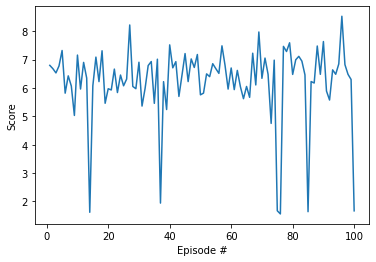

In [21]:
train_episodes = 100
print_every= 100

scores_deque = deque(maxlen=print_every)
scores = []

for i_episode in range(1,train_episodes+1):
    
    # reset the environment
    obs = env.reset()
    agent.reset()
    ep_rwds = []
    score = 0
    while True:
        action = agent.act(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.step(obs, action, reward, next_obs, done)
        obs = next_obs
        score+= reward
        ep_rwds.append(reward)
        if done:
            break
            
    scores_deque.append(score)
    scores.append(score)
    print('\rEpisode {}\tAverage Score: {:.2f}\n'.format(i_episode, np.mean(scores_deque)), end="")
    torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    #print(ep_rwds)
    #if i_episode % print_every == 0:
    #    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    
    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show() 